# 2_data_preparation_suto

In [71]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sqlalchemy import create_engine

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [72]:
df_data = pd.read_parquet(path_interim_data+"df_data_step_1_output.pqt")

print(f"Dimensões do dataset: {df_data.shape}")

df_data.sample(3, random_state=42)

Dimensões do dataset: (397, 10)


,car name,car brand,model year,cylinders,displacement,horsepower,weight,acceleration,origin,mpg
114,datsun 210,datsun,80,4,85.0,65.0,2110.0,19.2,3.0,40.8
278,peugeot 504,peugeot,76,4,120.0,88.0,3270.0,21.9,2.0,19.0
237,mazda 626,mazda,81,4,120.0,74.0,2635.0,18.3,3.0,31.6


In [73]:
X = df_data.drop(['mpg'], axis=1)
y = df_data['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"""Dimensão do conjunto de treino: {X_train.shape}
Dimensão do conjunto de validação: {X_test.shape}""")

Dimensão do conjunto de treino: (357, 9)
Dimensão do conjunto de validação: (40, 9)


## Dados categóricos

Existem apenas dois atributos categóricos:
- *car name*
- *car brand*

Não faz sentido usar o nome do carro (*car name*) como preditor do desempenho e, por isso, esse atributo será removido.

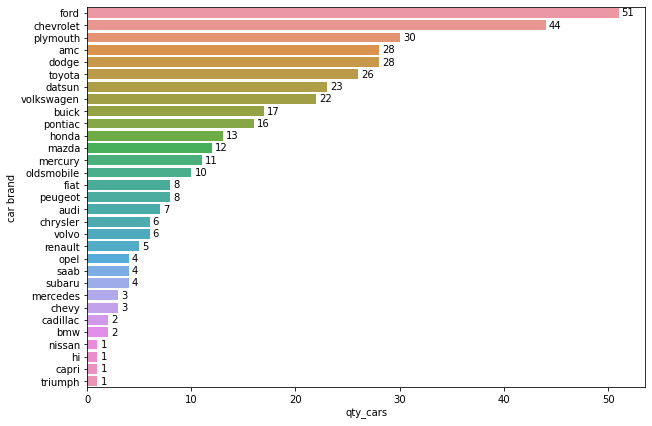

In [74]:
df_data_categorical = df_data['car brand']

car_dist = (df_data.groupby(['car brand']).agg({'car name':'count'}).rename(columns={'car name':'qty_cars'}).
            reset_index().sort_values(by='qty_cars', ascending=False))

plt.figure(figsize=(10,7))
bx = sns.barplot(y='car brand', x='qty_cars', data=car_dist)

for i, v in enumerate(car_dist['qty_cars']):
    bx.text(v + 0.3, i + .25, str(v))

Para tratar esse atributo e usá-lo, temos três possibilidades:

1. One hot encoding *(como o atributo tem uma cardinalidade alta e pode introduzir mais variância ao modelo)*
1. **Rare label encoding** *(posso perder informação de uma marca em relação ao desempenho pois as classes menos frequentes se juntarão numa única classe)*
1. **Count frequency categorical encoder** *(vou apostar nessa abordagem em conjunto com o **Rare label encoding**)*

In [75]:
pipe = Pipeline([('RareLabel', ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=4, variables=['car brand'], replace_with='Rare'))
                 , ('CountFrequency', ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables=['car brand']))])

X_train_encoded = pipe.fit_transform(X_train)
X_test_encoded = pipe.transform(X_test)

X_train_encoded.drop(['displacement', "horsepower", "weight", "acceleration"], axis=1, inplace=True)
X_test_encoded.drop(['displacement', "horsepower", "weight", "acceleration"], axis=1, inplace=True)

X_poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = pd.DataFrame(X_poly.fit_transform(X_train[['displacement', "horsepower", "weight", "acceleration"]]),
                            columns=X_poly.get_feature_names(['displacement', "horsepower", "weight", "acceleration"]),
                            index=X_train.index)
X_train_encoded = pd.concat([X_train_encoded, X_train_poly], axis=1)

X_poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = pd.DataFrame(X_poly.fit_transform(X_test[['displacement', "horsepower", "weight", "acceleration"]]),
                           columns=X_poly.get_feature_names(['displacement', "horsepower", "weight", "acceleration"]),
                           index=X_test.index)
X_test_encoded = pd.concat([X_test_encoded, X_test_poly], axis=1)


print(f"""Dimenões antes das tranformações:
Treino: {X_train.shape}
Validação: {X_test.shape}
---------------------------------
Dimenões APÓS tranformações:
Treino: {X_train_encoded.shape}
Validação: {X_test_encoded.shape}""")

Dimenões antes das tranformações:
Treino: (357, 9)
Validação: (40, 9)
---------------------------------
Dimenões APÓS tranformações:
Treino: (357, 19)
Validação: (40, 19)


## Extração para a próxima etapa

In [76]:
X_train_encoded.to_parquet(path_interim_data+"X_train_encoded_step_2.pqt")
X_test_encoded.to_parquet(path_interim_data+"X_test_encoded_2_output.pqt")

In [77]:
# ls_continuous_features = df_data.select_dtypes(include=[float]).columns
# ls_continuous_features

# df_data_step_2_output = df_data.copy()
# df_data_step_2_output = df_data_step_2_output[ls_continuous_features]

# df_data_step_2_output.to_parquet(path_interim_data+"df_data_step_2_output.pqt")